# Определение стоимости автомобилей


>[Определение стоимости автомобилей](#scrollTo=-UJOEedi5EDg)

>>>[Описание проекта](#scrollTo=r9hOvGPq5NWD)

>>>[Описание данных](#scrollTo=YP2EU1AD5EDh)

>>[Подготовка данных](#scrollTo=dgfb9vjw5EDh)

>>>[1.1. Импорт библиотек](#scrollTo=dKHetfwB6rk4)

>>>[1.2. Загрузка данных](#scrollTo=YljPImPC6pCx)

>>>[1.3. Предобработка](#scrollTo=aPEGifB57AZA)

>>>>[1.3.1. Дубликаты](#scrollTo=Jzos-4ym7B5x)

>>>>[1.3.2. Изменение типов данных](#scrollTo=JUoeENRJ5EDj)

>>>[1.4. Исследовательский анализ и обработка](#scrollTo=cACNVofW5EDk)

>>>>[1.4.1. Категориальные признаки](#scrollTo=ibbbhWGS7iFA)

>>>>[1.4.2. Количественные признаки](#scrollTo=NgzfqTmH7rN4)

>>>>>[1.4.2.1. Price](#scrollTo=vfeWFE9d7u6g)

>>>>>[1.4.2.2. RegistrationYear](#scrollTo=k2vx6uQn7_I5)

>>>>>[1.4.2.3. Power](#scrollTo=dr5vtqwE8HIy)

>>>>>[1.4.2.4. Kilometer](#scrollTo=sjeIdBSA5EDw)

>>>>[1.4.3. Корреляционный анализ](#scrollTo=APgd7wOt80nT)

>>>[Вывод по шагу 1](#scrollTo=1c1tQn6w9e9I)

>>[Обучение моделей](#scrollTo=0EITa8qX5EDw)

>>>[2.1. Разделение на выборки, заполнение пропусков](#scrollTo=bXVNAMf29qke)

>>>[2.2. SVR](#scrollTo=Ui5jJ8Qr9yQp)

>>>[2.3. LGBMRegressor](#scrollTo=lR5dYjuq-ZSI)

>>>[Вывод по шагу 2](#scrollTo=qTIOVVhU5EDy)

>>[Анализ моделей](#scrollTo=LJQ3-YNF5EDy)

>>>[Вывод по шагу 3](#scrollTo=uXw65sgS5EDy)

>>[Тестирование лучшей модели](#scrollTo=Ja1Xpv6x5EDz)

>>[Итоговые выводы](#scrollTo=9Lz8u94E5EDz)



### Описание проекта

Сервис по продаже автомобилей с пробегом "Не бит, не крашен" разрабатывает приложение для привлечения новых клиентов. В нем можно быстро узнать рыночную стоимость своего автомобиля. Даны исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Попробуем обучить две модели: `LightGBM` и `SVR`. Выберем наилучшую с учетом приоритетов заказчика, а также требования:
- значение метрики RMSE должно быть меньше 2500.

### Описание данных

Дана одна таблица (файл `autos.csv`) со следующими признаками:

|название столбца|содержащиеся данные|
|:-|:-|
|`DateCrawled`|дата скачивания анкеты из базы|
|`VehicleType`|тип автомобильного кузова|
|`RegistrationYear`|год регистрации автомобиля|
|`Gearbox`|тип коробки передач|
|`Power`|мощность (в лошадиных силах)|
|`Model`|модель автомобиля|
|`Kilometer`|пробег (в километрах)|
|`RegistrationMonth`|месяц регистрации автомобиля|
|`FuelType`|тип топлива|
|`Brand`|марка автомобиля|
|`Repaired`|была машина в ремонте или нет|
|`DateCreated`|дата создания анкеты|
|`NumberOfPictures`|количество фотографий автомобиля|
|`PostalCode`|почтовый индекс владельца анкеты (пользователя)|
|`LastSeen`|дата последней активности пользователя|
|`Price`|цена (в евро), **целевой признак**|


## 1. Подготовка данных



### 1.1. Импорт библиотек

In [ ]:
! pip install numpy==1.22.0 -q
! pip install matplotlib==3.7.3 -q
! pip install phik -q
! pip install -U scikit-learn -q
! pip install lightgbm -q


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.3.0 requires numpy>=1.23, but you have numpy 1.22.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import phik
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from pathlib import Path
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV,
    train_test_split)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    TargetEncoder,
    StandardScaler,
    RobustScaler
)

sns.set_style('whitegrid')

RANDOM_STATE = 42

In [ ]:
def show_num(data, col):
    """
    Принимает:
        наименование переменной, хранящей датафрейм;
        наименование столбца с количественными данными в этом датафрейме.
    Возвращает:
        общее описание данных;
        гистограмму с наложенным графиком плотности распределения;
        диаграмму размаха.
    """
    figure, axs = plt.subplots(1, 2, figsize=(15, 8))
    figure.suptitle(col.title())

    sns.histplot(data[col], bins=50, kde=True, ax=axs[0])
    axs[0].set_title('Гистограмма и плотность расределения')

    sns.boxplot(data=data[col], ax=axs[1])
    axs[1].set_title('Диаграмма размаха')

    plt.show()

    display(data[col].describe().to_frame())
    print('Число пропусков:', data[col].isna().sum())

def show_cat(data, col):
    """
    Принимает:
        наименование переменной, хранящей датафрейм;
        наименование столбца с категориальными данными в этом датафрейме.
    Возвращает:
        столбчатую диаграмму;
        абсолютное количество и долю для каждого уникального значения.
    """
    plt.figure(figsize=(12, 12))
    sns.countplot(
        x=data[col],
        palette='blend:#a27ade,#63cfb0'
    )
    plt.title(f'{col}: столбчатая диаграмма')
    plt.xticks(rotation=90)
    plt.show()

    frame = data[col].value_counts().to_frame()
    frame['proportion'] = round((frame[col] / data.shape[0]), 2)
    frame.columns = ['count', 'proportion']
    display(frame.sort_values(by='count', ascending=False))
    print('Число пропусков:', data[col].isna().sum())

### 1.2. Загрузка данных


In [ ]:
path_pract = Path('/datasets/autos.csv')
path_google = Path('/content/drive/MyDrive/datasets/autos.csv')

if path_pract.exists():
    autos = pd.read_csv(path_pract)
elif path_google.exists():
    autos = pd.read_csv(path_google)
else:
    raise FileNotFoundError('Both paths do not exist')

display(autos.head(20))
print(autos.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Таблица адекватно отображается.
Сразу можно отметить:
* для целей определения цены не имеют значения столбцы `DateCrawled`, `RegistrationMonth`, `DateCreated`, `PostalCode`, `LastSeen`;
* большое число пропусков в некоторых столбцах (`VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`);
* тип данных в столбцах с датами не соответствует ожидаемому `datetime`;
* присутствуют аномальные значения (0 в `Price`, `Power`, `RegistrationMonth`).



### 1.3. Предобработка


#### 1.3.1. Дубликаты
Определим количество явных дубликатов в таблице. Скрытые дубликаты, если таковые обнаружатся в ходе исследовательского анализа, обработаем позже в пайплайне.

In [ ]:
print(autos.duplicated().sum())

4


Дубликатов мало, можно их удалить.

In [ ]:
autos = autos.drop_duplicates().reset_index(drop=True)
print(autos.duplicated().sum())

0


Удаление прошло нормально.
#### 1.3.2. Изменение типов данных
Столбцы `DateCreated` и `LastSeen` не нужны для предсказания цены, мы не будем их использовать в обучении, поэтому преобразовывать нет смысла.
Приведем дату скачивания к соответствующему типу данных и проверим, когда выгружены данные, чтобы убедиться в их однородности.

In [ ]:
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
print(pd.DatetimeIndex(autos['DateCrawled']).year.value_counts())

2016    354365
Name: DateCrawled, dtype: int64


Все данные выгружены в 2016 году. Можно оставить только столбцы со значимыми данными и приступить к анализу.

In [ ]:
autos = autos[['Price',
              'VehicleType',
              'RegistrationYear',
              'Gearbox',
              'Power',
              'Model',
              'Kilometer',
              'FuelType',
              'Brand',
              'Repaired',
              'NumberOfPictures']]

### 1.4. Исследовательский анализ и обработка


#### 1.4.1. Категориальные признаки

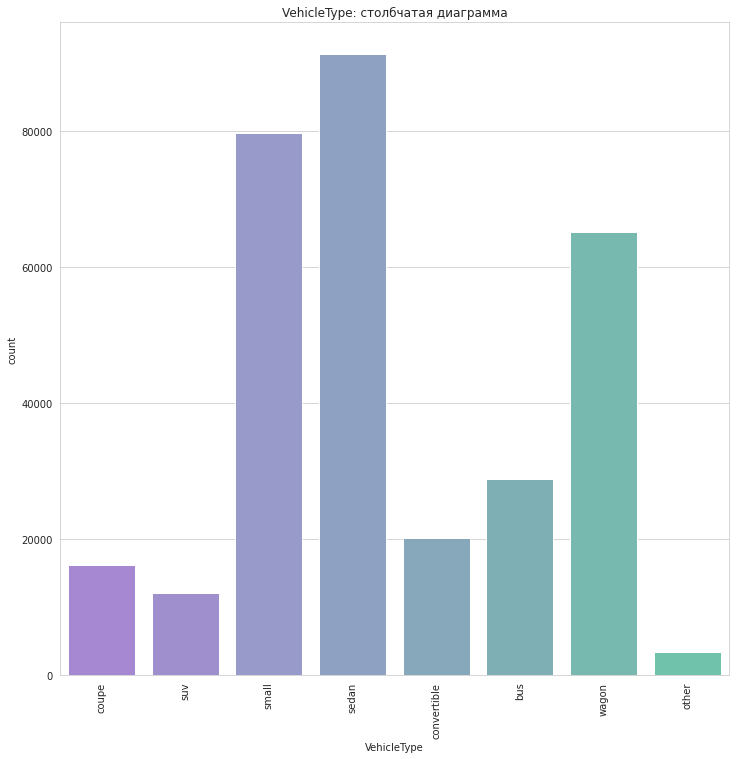

,count,proportion
sedan,91457,0.26
small,79830,0.23
wagon,65165,0.18
bus,28775,0.08
convertible,20203,0.06
coupe,16161,0.05
suv,11996,0.03
other,3288,0.01


Число пропусков: 37490


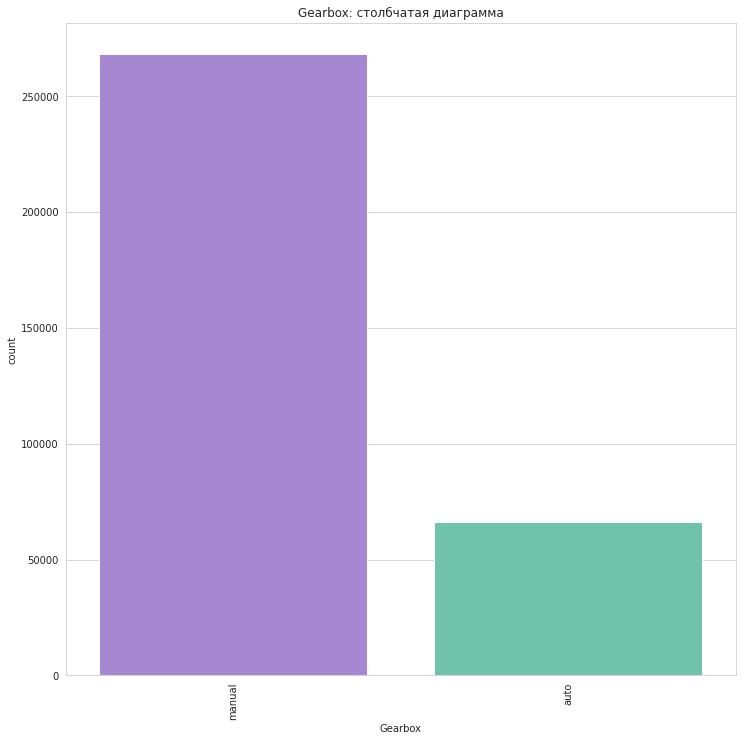

,count,proportion
manual,268249,0.76
auto,66283,0.19


Число пропусков: 19833


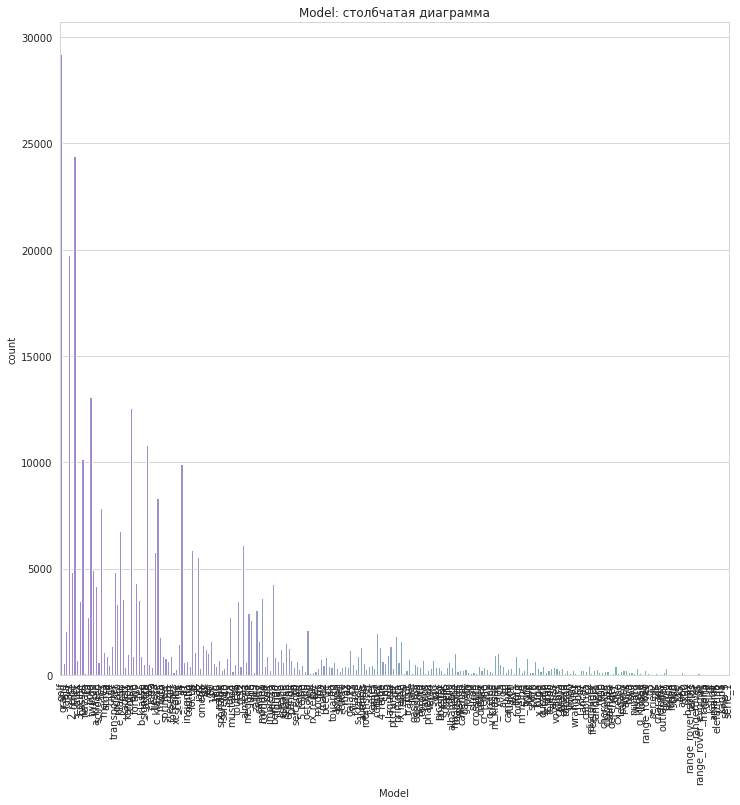

,count,proportion
golf,29232,0.08
other,24420,0.07
3er,19761,0.06
polo,13066,0.04
corsa,12570,0.04
...,...,...
serie_2,8,0.00
rangerover,4,0.00
serie_3,4,0.00
range_rover_evoque,2,0.00


Число пропусков: 19705


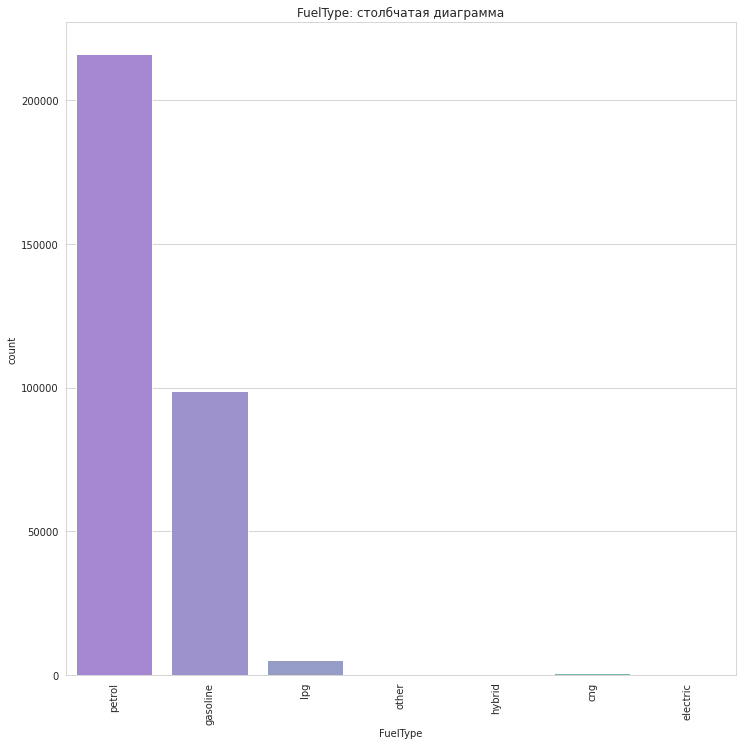

,count,proportion
petrol,216349,0.61
gasoline,98719,0.28
lpg,5310,0.01
cng,565,0.00
hybrid,233,0.00
other,204,0.00
electric,90,0.00


Число пропусков: 32895


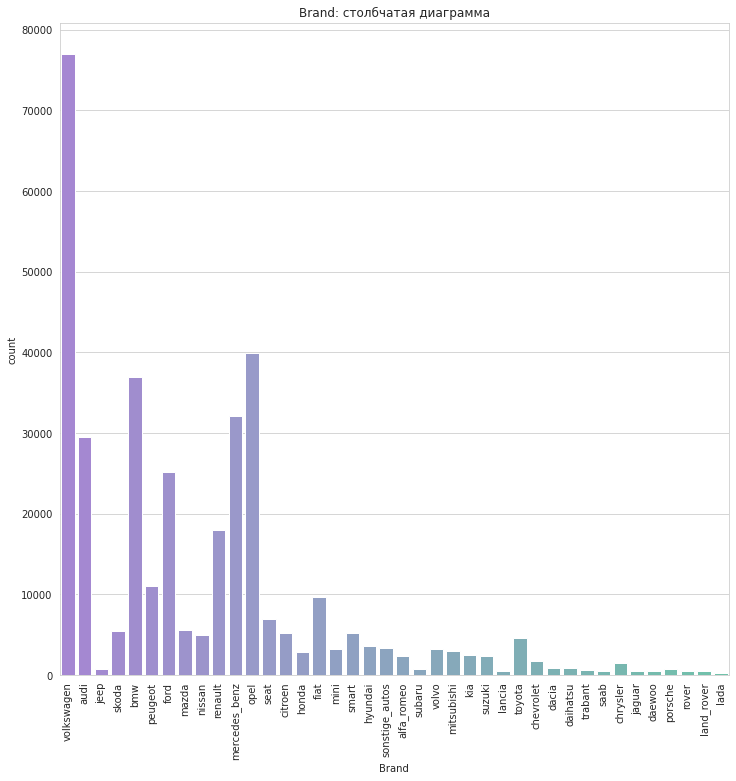

,count,proportion
volkswagen,77012,0.22
opel,39931,0.11
bmw,36914,0.10
mercedes_benz,32044,0.09
audi,29456,0.08
ford,25179,0.07
renault,17927,0.05
peugeot,10998,0.03
fiat,9643,0.03
seat,6907,0.02


Число пропусков: 0


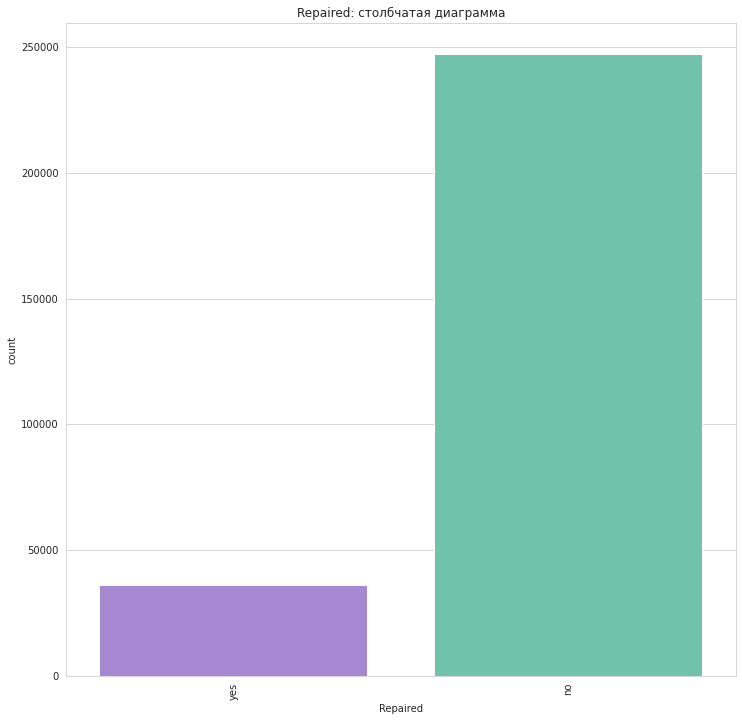

,count,proportion
no,247158,0.7
yes,36053,0.1


Число пропусков: 71154


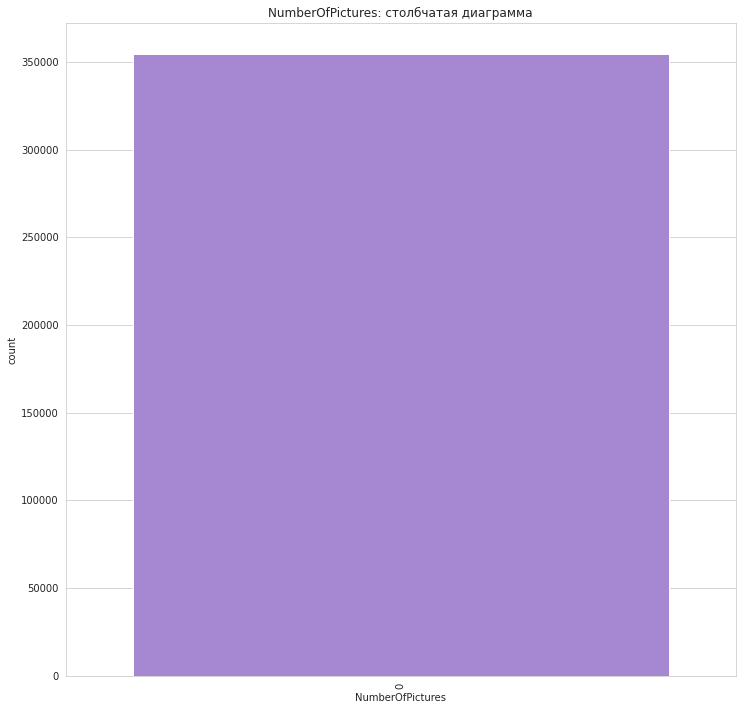

,count,proportion
0,354365,1.0


Число пропусков: 0


In [ ]:
cat_cols = ['VehicleType',
            'Gearbox',
            'Model',
            'FuelType',
            'Brand',
            'Repaired',
            'NumberOfPictures']
for col in cat_cols:
    show_cat(autos, col)

Видим, что:
* скрытых дубликатов нет (возможно, за исключением столбца `Model`, в котором слишком много уникальных значений, мешающих адекватной визуализации);
* столбец `NumberOfPictures` не информативен, его можно не включать во входные признаки;
* пропуски в столбце `Repaired` нельзя удалить из-за большого количества и невозможно восстановить на основании других признаков, поэтому имеет смысл заменить "заглушкой" `unknown`;
* пропуски в столбце `Model` можно заменить модой по `Brand`, а пропуски в других столбцах – уже на основании `Model`.

In [ ]:
for b in autos['Brand'].unique():
    autos.loc[
        (autos['Brand'] == b) & (autos['Model'].isna()),
        'Model'] = \
    autos.loc[
        (autos['Brand'] == b) & (autos['Model'] != 'Nan'),
        'Model'].mode()
print(autos['Model'].isna().sum())

19705


Осталось меньше 5 тысяч пропусков в столбце `Model`, их можно удалить, особенно если в этих строках часто оказываются пропущены и другие столбцы.

In [ ]:
display(autos.loc[autos['Model'].isna()].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19705 entries, 1 to 354361
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             19705 non-null  int64 
 1   VehicleType       12877 non-null  object
 2   RegistrationYear  19705 non-null  int64 
 3   Gearbox           15574 non-null  object
 4   Power             19705 non-null  int64 
 5   Model             0 non-null      object
 6   Kilometer         19705 non-null  int64 
 7   FuelType          12542 non-null  object
 8   Brand             19705 non-null  object
 9   Repaired          10651 non-null  object
 10  NumberOfPictures  19705 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.8+ MB


None

In [ ]:
autos = autos.dropna(subset=['Model'])
print(autos.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             334660 non-null  int64 
 1   VehicleType       303998 non-null  object
 2   RegistrationYear  334660 non-null  int64 
 3   Gearbox           318958 non-null  object
 4   Power             334660 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         334660 non-null  int64 
 7   FuelType          308928 non-null  object
 8   Brand             334660 non-null  object
 9   Repaired          272560 non-null  object
 10  NumberOfPictures  334660 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 30.6+ MB
None


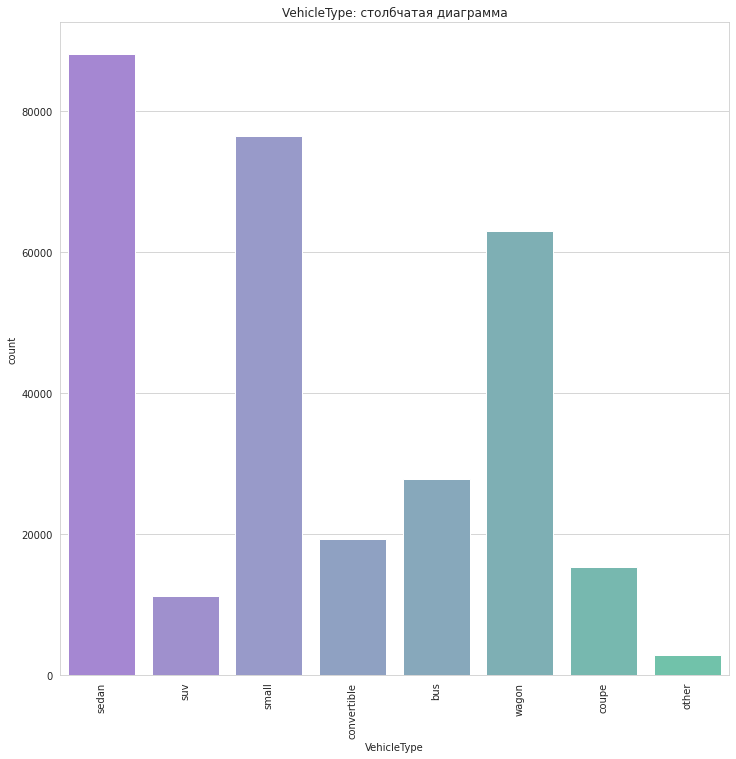

,count,proportion
sedan,88120,0.26
small,76493,0.23
wagon,62995,0.19
bus,27794,0.08
convertible,19319,0.06
coupe,15237,0.05
suv,11237,0.03
other,2804,0.01


Число пропусков: 30661


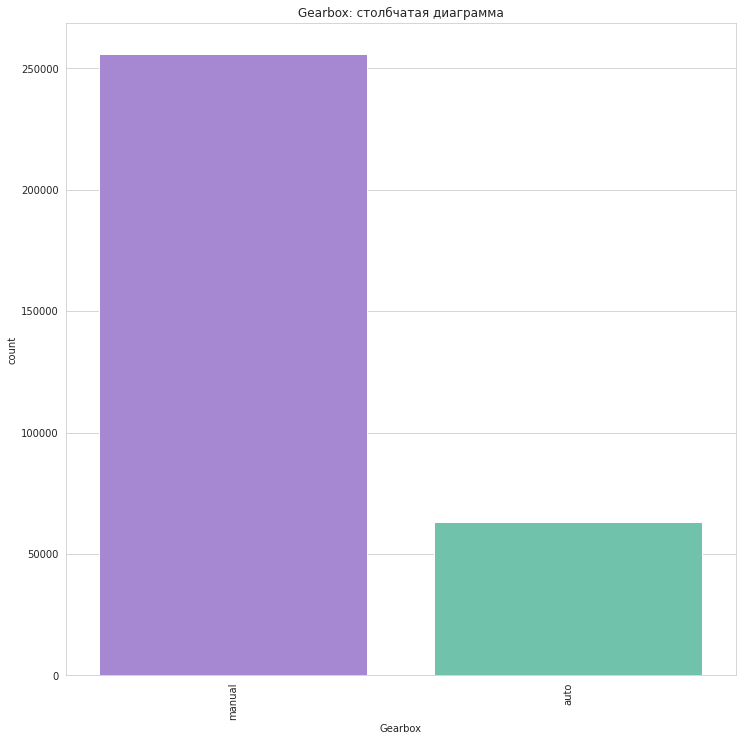

,count,proportion
manual,255922,0.76
auto,63036,0.19


Число пропусков: 15702


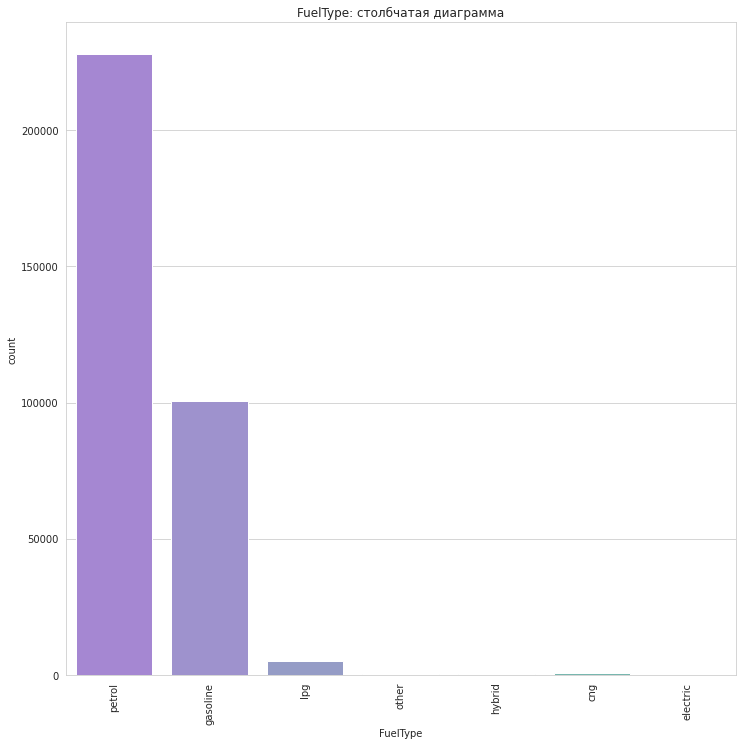

,count,proportion
petrol,228193,0.68
gasoline,100554,0.30
lpg,4962,0.01
cng,544,0.00
hybrid,208,0.00
other,133,0.00
electric,66,0.00


Число пропусков: 0


In [ ]:
for m in autos['Model'].unique():
    autos.loc[(autos['Model'] == m) & (autos['VehicleType'].isna()), 'VehicleType'] = \
    autos.loc[(autos['Model'] == m) & (autos['VehicleType'] != 'Nan'), 'VehicleType'].mode()

    autos.loc[(autos['Model'] == m) & (autos['Gearbox'].isna()), 'Gearbox'] = \
    autos.loc[(autos['Model'] == m) & (autos['Gearbox'] != 'Nan'), 'Gearbox'].mode()

    autos.loc[(autos['Model'] == m) & (autos['FuelType'].isna()), 'FuelType'] = \
    autos.loc[(autos['Model'] == m) & (autos['FuelType'] != 'Nan'), 'FuelType'].mode()[0]

for col in ['VehicleType', 'Gearbox', 'FuelType']:
    show_cat(autos, col)

Некоторые значения удалось восстановить, однако пропусков по-прежнему много. Заменим их "заглушкой" `unknown` позже в пайплайне.

Перейдем к количественным признакам.


#### 1.4.2. Количественные признаки

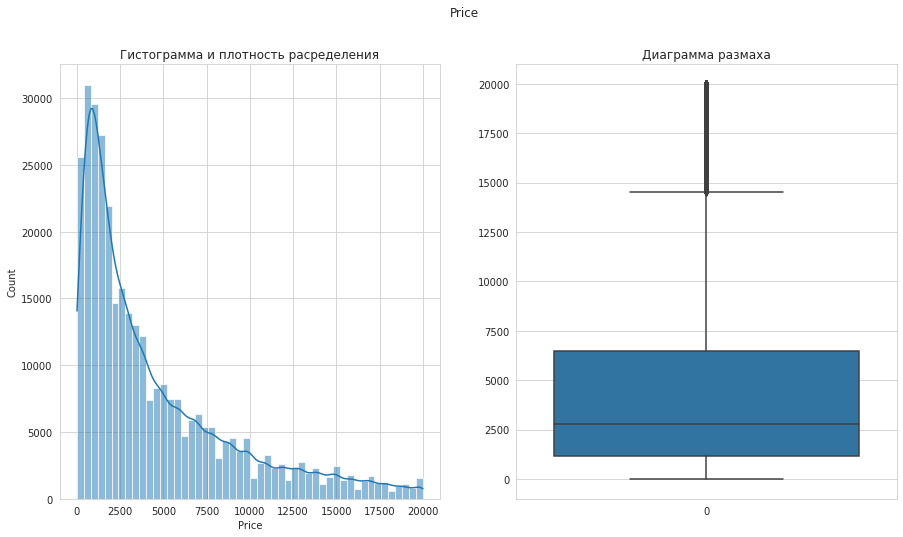

,Price
count,334660.000000
mean,4504.372249
std,4531.457109
min,0.000000
25%,1150.000000
50%,2800.000000
75%,6500.000000
max,20000.000000


Число пропусков: 0


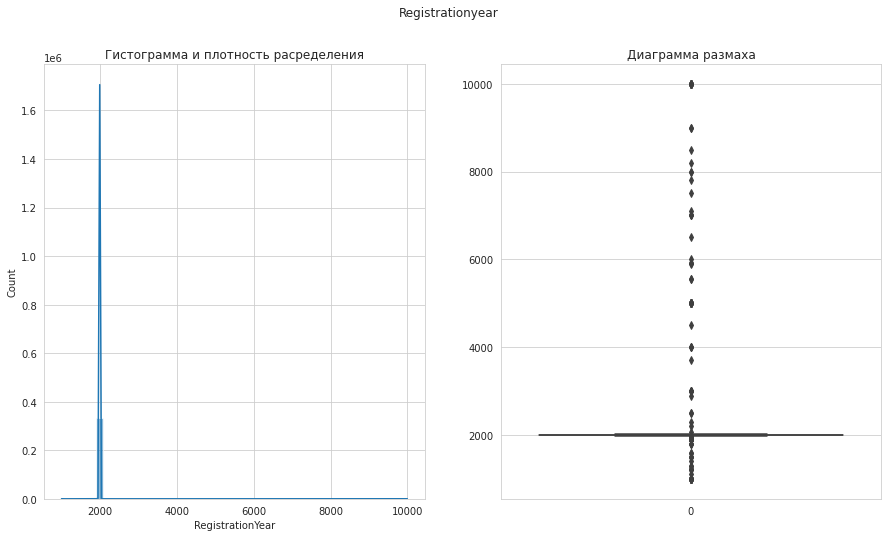

,RegistrationYear
count,334660.000000
mean,2003.924024
std,69.377633
min,1000.000000
25%,1999.000000
50%,2003.000000
75%,2008.000000
max,9999.000000


Число пропусков: 0


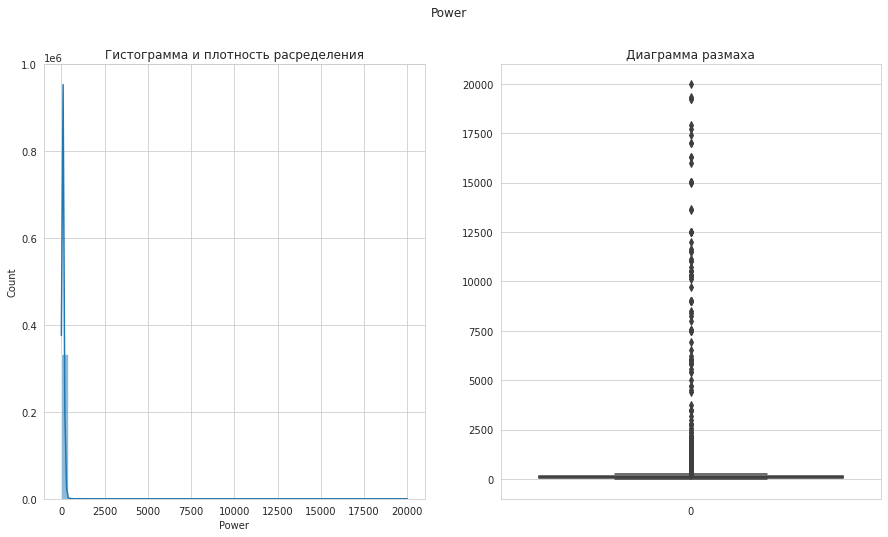

,Power
count,334660.000000
mean,111.372659
std,185.157391
min,0.000000
25%,70.000000
50%,105.000000
75%,143.000000
max,20000.000000


Число пропусков: 0


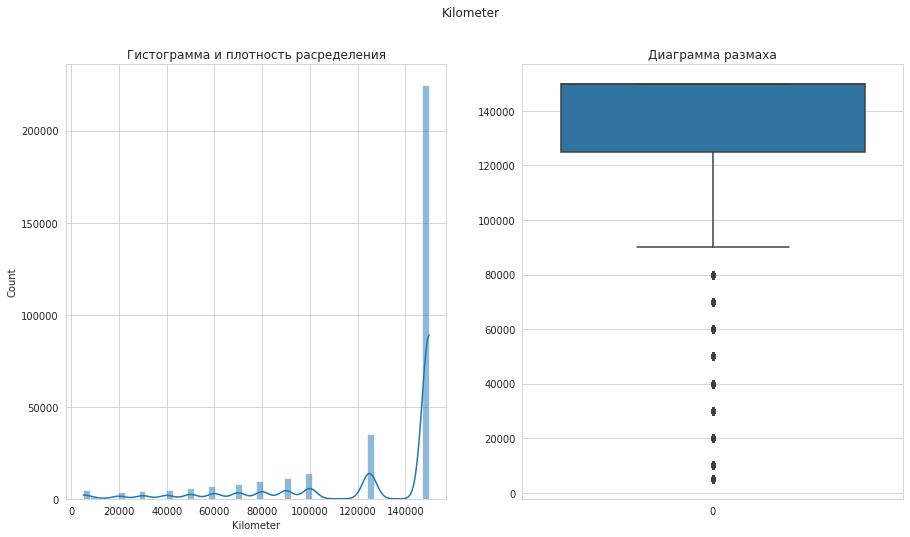

,Kilometer
count,334660.000000
mean,128562.795076
std,37205.638630
min,5000.000000
25%,125000.000000
50%,150000.000000
75%,150000.000000
max,150000.000000


Число пропусков: 0


In [ ]:
num_cols = ['Price',
            'RegistrationYear',
            'Power',
            'Kilometer']
for col in num_cols:
    show_num(autos, col)

Во всех столбцах есть выбросы и аномальные значения, которые необходимо обработать. Явных пропусков нет, но присутствуют нулевые значения, по смыслу эквивалентные пропускам (столбцы `Price` и `Power`).

Рассмотрим и обработаем каждый столбец в отдельности.


##### 1.4.2.1. `Price`
Имеем большое число автомобилей с ценой равной или близкой к нулю. Это едва ли можно счесть аномальным значением, поскольку в реальности существуют люди, готовые отдать старую ненужную вещь бесплатно или за символическую стоимость, однако такие данные могут помешать определению рыночной цены. Проверим, как много машин продаются меньше, чем за 300 евро. Если их меньше 30 тысяч, можно удалить такие строки (общее количество удаленных строк останется в пределах 10% от первоначального количества).

In [ ]:
print(autos.loc[autos['Price'] < 300, 'Price'].count())

19430


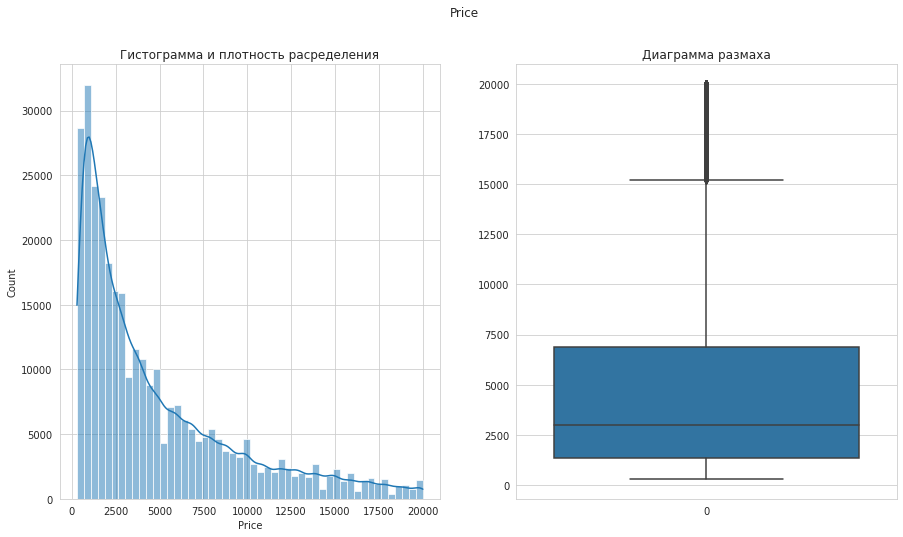

,Price
count,315230.000000
mean,4776.322913
std,4530.484169
min,300.000000
25%,1350.000000
50%,3000.000000
75%,6890.000000
max,20000.000000


Число пропусков: 0


In [ ]:
autos = autos.loc[autos['Price'] >= 300]
show_num(autos, 'Price')

Цены выше 15000 расцениваются как выбросы. Однако все они лежат в пределах 20000, и не являются аномальными значениями. Проверим, сколько их. Если дорогих машин окажется много (больше 5 тысяч), оставим эти данные.

In [ ]:
print(autos.loc[autos['Price'] > 15000, 'Price'].count())

14413


Таким образом, имеем довольно большой разброс цен: от 300 до 20000, медиана меньше среднего, большинство значений в промежутке от 1300 до 6750.


##### 1.4.2.2. `RegistrationYear`
Выше мы видели, что большинство значений находятся в рамках между 1999 и 2008, но присутствует много аномальных значений. Рассмотрим все уникальные аномальные значения в этом столбце. Аномальными можно считать значения меньше 1900 и больше 2016 (год выгрузки записей).

In [ ]:
print('До 1900', autos.loc[(autos['RegistrationYear'] < 1900), 'RegistrationYear'].value_counts())
print()
print('После 2016', autos.loc[(autos['RegistrationYear'] > 2016), 'RegistrationYear'].value_counts())

До 1900 1000    8
1800    2
1600    1
1602    1
1300    1
1400    1
1001    1
1500    1
Name: RegistrationYear, dtype: int64

После 2016 2017    8400
2018    3233
2019      13
9999       8
5000       7
5555       2
4000       2
5911       2
7000       2
8500       1
9000       1
4500       1
3700       1
2900       1
2500       1
7800       1
8200       1
2200       1
2290       1
2066       1
6000       1
7100       1
Name: RegistrationYear, dtype: int64


Неправдоподобно маленьких значений года регистрации очень мало, можно удалить эти записи. То же самое с годами регистрации больше 2018. Однако машин, якобы зарегистрированных в 2017 и 2018 годах достаточно много. Удалить их все нельзя. Изменим эти годы на 2016, так как это ближайший правдоподобный год.

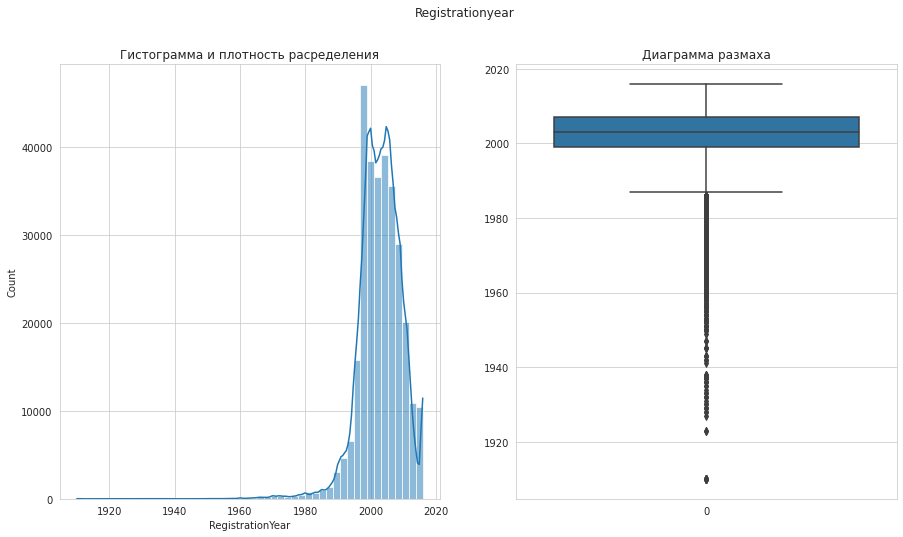

,RegistrationYear
count,303532.000000
mean,2002.882329
std,6.547057
min,1910.000000
25%,1999.000000
50%,2003.000000
75%,2007.000000
max,2016.000000


Число пропусков: 0


In [ ]:
autos.loc[
    (autos['RegistrationYear'] == 2017) | (autos['RegistrationYear']) == 2018,
    'RegistrationYear'
] = 2016
autos = autos.loc[(autos['RegistrationYear'] >= 1900) & (autos['RegistrationYear'] <= 2016)]
show_num(autos, 'RegistrationYear')

Годы регистрации винтажных и антикварных автомобилей по-прежнему расцениваются как выбросы, однако их нужно оставить, чтобы цену таких машин тоже можно было предсказать. В остальном распределение выглядит похожим на нормальное биномиальное, с медианой близкой к среднему. Большинство автомобилей зарегистрированы в промежутке от 1999 до 2007.

##### 1.4.2.3. `Power`
Выше мы видели в этом столбце много нулей и неадекватно больших значений. Нулевую мощность можно счесть пропущенной и попробовать восстановить по медиане для той же модели. Слишком большие значения, похоже, просто имеют лишние порядки. Рассмотрим все подозрительные значения столбца подробнее.

In [ ]:
print('Меньше 10', autos.loc[(autos['Power'] < 10) & (autos['Power'] != 0), 'Power'].value_counts())

Меньше 10 1    15
5    13
8     5
2     4
4     4
6     3
7     3
9     2
3     1
Name: Power, dtype: int64


In [ ]:
display(autos.loc[(autos['Power'] < 10) & (autos['Power'] != 0)])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures
3349,1990,small,2004,NaN,7,polo,150000,gasoline,volkswagen,no,0
9561,9000,sedan,2009,manual,2,a4,5000,gasoline,audi,NaN,0
20229,4999,sedan,2003,manual,1,e_klasse,150000,gasoline,mercedes_benz,NaN,0
33068,5950,small,2004,manual,4,golf,80000,petrol,volkswagen,no,0
33223,3900,convertible,2004,auto,1,forfour,90000,petrol,smart,no,0
33995,4999,small,2012,auto,5,other,5000,electric,renault,no,0
34378,655,NaN,1995,manual,5,other,70000,petrol,seat,NaN,0
37733,1300,wagon,1999,auto,9,other,30000,petrol,citroen,no,0
42961,4200,other,2012,auto,8,other,40000,electric,renault,no,0
44179,500,small,1998,auto,7,1_reihe,100000,petrol,peugeot,no,0


Для автомобилей, выпущенных примерно до 1970 года, маленькая мощность двигателя нормальна, но для более поздних лет такие значения аномальны. Попробуем их тоже восстановить по `Model`.

In [ ]:
for m in autos['Model'].unique():
    autos.loc[(autos['Model'] == m) & (autos['Power'] == 0), 'Power'] = \
    autos.loc[(autos['Model'] == m) & (autos['Power'] != 0), 'Power'].median()

    autos.loc[(autos['Model'] == m) & (autos['Power'] < 10) & (autos['RegistrationYear'] > 1930), 'Power'] = \
    autos.loc[(autos['Model'] == m) & (autos['Power'] != 0), 'Power'].median()
display(autos.loc[(autos['Power'] < 10) & (autos['Power'] != 0)])

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures
324046,8750,convertible,1923,manual,8.0,c3,5000,petrol,citroen,no,0


Подозрительные маленькие значения устранены, перейдем к подозрительно большим.

In [ ]:
print('Больше 1500')
print(autos.loc[
    autos['Power'] > 1500, 'Power'
].value_counts().reset_index().sort_values(by='Power'))

Больше 1500
     index  Power
61  1933.0      1
90  6006.0      1
89  1995.0      1
88  2598.0      1
87  3199.0      1
..     ...    ...
15  1781.0      2
9   1595.0      2
2   1600.0      3
1   1800.0      5
0   1598.0      5

[124 rows x 2 columns]


Слишком больших значений очень много и их диапазон велик. Проверим, какие производители у таких машин.

In [ ]:
print(autos.loc[
    autos['Power'] > 1500, 'Brand'
].value_counts())

volkswagen       32
opel             25
audi             15
mercedes_benz    14
bmw              14
renault          10
ford              9
fiat              5
citroen           4
mini              3
alfa_romeo        2
seat              2
toyota            2
smart             2
chevrolet         2
daewoo            1
kia               1
volvo             1
suzuki            1
mitsubishi        1
skoda             1
Name: Brand, dtype: int64


Известных производителей сверхмощных спортивных машин в этом списке нет. Скорее всего, все эти значения ошибочны. Последовательно снизим порядок чисел.

In [ ]:
autos.loc[autos['Power'] > 1500, 'Power'] /= 10
autos.loc[autos['Power'] > 1500, 'Power'] /= 10
print(autos.loc[autos['Power'] > 1500, 'Power'].count())

0


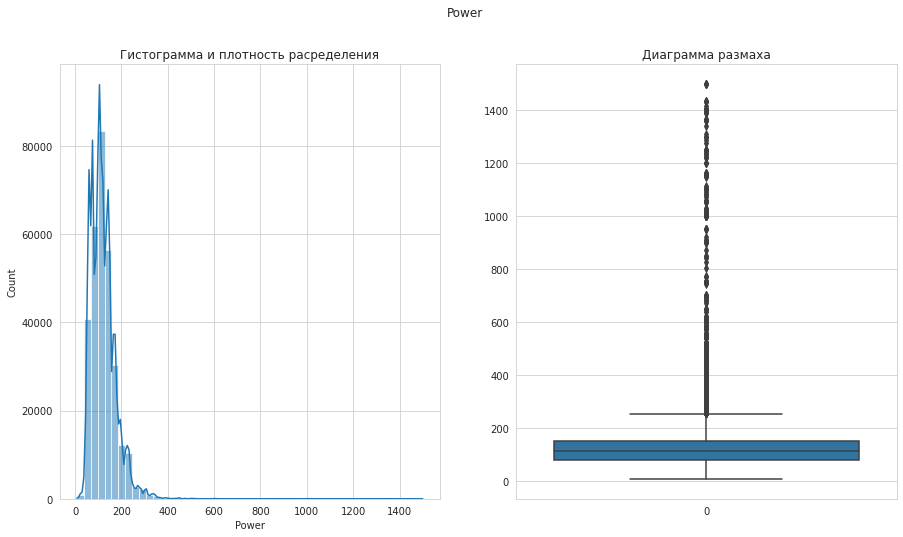

,Power
count,303531.000000
mean,121.291485
std,56.997536
min,8.000000
25%,80.000000
50%,115.000000
75%,150.000000
max,1500.000000


Число пропусков: 1


In [ ]:
show_num(autos, 'Power')

Остается длинный хвост выбросов справа, избавиться от которых не представляется возможным. В остальном распределение выглядит нормальным. Среднее близко к медиане, подавляющее большинство значений колеблется от 80 до 150. Это характерная величина мощности среднестатистических легковых автомобилей.

Кроме того, не удалось заполнить 1 пропущенное значение. Его можно удалить.

In [ ]:
autos = autos.dropna(subset=['Power'])
print(autos.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303531 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             303531 non-null  int64  
 1   VehicleType       290082 non-null  object 
 2   RegistrationYear  303531 non-null  int64  
 3   Gearbox           292512 non-null  object 
 4   Power             303531 non-null  float64
 5   Model             303531 non-null  object 
 6   Kilometer         303531 non-null  int64  
 7   FuelType          303531 non-null  object 
 8   Brand             303531 non-null  object 
 9   Repaired          255157 non-null  object 
 10  NumberOfPictures  303531 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 27.8+ MB
None


##### 1.4.2.4. `Kilometer`
Распределение пробега выглядит странно: подавляющее большинство значений равно 150000. Возможно, это связано с особенностями сбора данных (например, такое возможно, если пользователь отмечает пробег при помощи "бегунка" с максимальным значением 150000; или если это значение по умолчанию).

Распределение будет выглядеть более правдоподобным, если снизить порядок этого числа, однако неизвестно, насколько это будет адекватно реальности. Поэтому пока оставим этот столбец как есть.

Однако при корреляционном анализе учтем, что этот признак более корректно рассматривать как дискретный, а не интервальный.

#### 1.4.3. Корреляционный анализ

Посмотрим на взаимосвязи признаков.

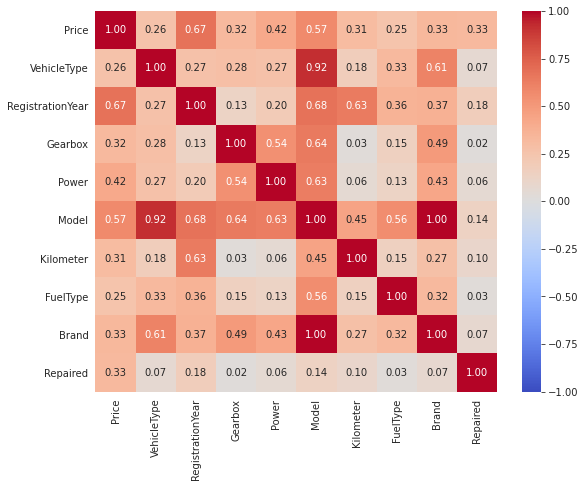

In [ ]:
corr_matrix = autos.drop(['NumberOfPictures'], axis=1).phik_matrix(interval_cols=[
    'Price',
    'Power'
])

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0
)
plt.show()

Все потенциальные входные признаки имеют взаимосвязи с целевым признаком:
* `RegistrationYear` и `Model` – сильные;
* `Gearbox`, `Power`, `Kilometer`, `Brand`, `Repaired` – средние;
* остальные – слабые.

При этом `Model` полностью зависиот от `Brand`, что было ожидаемо.

### Вывод по шагу 1

В данных очень большое количество пропусков, аномалий и выбросов, всего 4 дубликата.

Удалили 11% строк.

Пропуски в категориальных и количественных признаках частично восстановили модой для каждой модели. Пропуски, которые не представляется возможным восстановить, заменим на "заглушки" `unknown`.

Все потенциальные входные признаки имеют взаимосвязи с целевым признаком, но особенно сильной взаимосвязи у `Price` нет ни с одним из признаков. При этом `Model` полностью зависиот от `Brand`, что было ожидаемо.

## 2. Обучение моделей



### 2.1. Разделение на выборки, заполнение пропусков
Разделим данные на тренировочную, валидационную и тестовую выборки в соотношении 3:1:1.

Затем заполним оставшиеся пропуски.

In [ ]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(
    autos.drop([
        'Price',
        'NumberOfPictures'
    ],axis=1),
    autos['Price'],
    test_size=0.4,
    random_state=RANDOM_STATE)
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test_valid,
    y_test_valid,
    test_size=0.5,
    random_state=RANDOM_STATE)

In [ ]:
cat_columns = ['VehicleType',
               'Gearbox',
               'Model',
               'FuelType',
               'Brand',
               'Repaired']

imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='constant',
    fill_value='unknown')

cat_columns_imputed_train = pd.DataFrame(
    imputer.fit_transform(X_train[cat_columns]),
    columns=cat_columns
)
cat_columns_imputed_test = pd.DataFrame(
    imputer.transform(X_test[cat_columns]),
    columns=cat_columns
)
cat_columns_imputed_valid = pd.DataFrame(
    imputer.transform(X_valid[cat_columns]),
    columns=cat_columns
)
X_train_imputed = X_train[[
    'RegistrationYear',
    'Power',
    'Kilometer'
]].reset_index(drop=True).join(cat_columns_imputed_train)

X_test_imputed = X_test[[
    'RegistrationYear',
    'Power',
    'Kilometer'
]].reset_index(drop=True).join(cat_columns_imputed_test)

X_valid_imputed = X_valid[[
    'RegistrationYear',
    'Power',
    'Kilometer'
]].reset_index(drop=True).join(cat_columns_imputed_valid)

display(X_train_imputed.info())
display(X_test_imputed.info())
display(X_valid_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182118 entries, 0 to 182117
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   RegistrationYear  182118 non-null  int64  
 1   Power             182118 non-null  float64
 2   Kilometer         182118 non-null  int64  
 3   VehicleType       182118 non-null  object 
 4   Gearbox           182118 non-null  object 
 5   Model             182118 non-null  object 
 6   FuelType          182118 non-null  object 
 7   Brand             182118 non-null  object 
 8   Repaired          182118 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 12.5+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60706 entries, 0 to 60705
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RegistrationYear  60706 non-null  int64  
 1   Power             60706 non-null  float64
 2   Kilometer         60706 non-null  int64  
 3   VehicleType       60706 non-null  object 
 4   Gearbox           60706 non-null  object 
 5   Model             60706 non-null  object 
 6   FuelType          60706 non-null  object 
 7   Brand             60706 non-null  object 
 8   Repaired          60706 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 4.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60707 entries, 0 to 60706
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RegistrationYear  60707 non-null  int64  
 1   Power             60707 non-null  float64
 2   Kilometer         60707 non-null  int64  
 3   VehicleType       60707 non-null  object 
 4   Gearbox           60707 non-null  object 
 5   Model             60707 non-null  object 
 6   FuelType          60707 non-null  object 
 7   Brand             60707 non-null  object 
 8   Repaired          60707 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 4.2+ MB


None

Данные разделены на выборки, все пропуски заполнены. Перейдем к обучению моделей.

### 2.2. SVR
Сначала обучим модель `SVR` с ядром `rbf`. Для этого закодируем категориальные признаки и масштабируем количественные.

Поскольку заказчику важна скорость выполнения, отметим время, за которое модель обучается и выполняет предсказания.

In [ ]:
cat_columns = ['VehicleType',
               'Gearbox',
               'Model',
               'FuelType',
               'Brand',
               'Repaired']

num_columns = ['RegistrationYear',
               'Power',
               'Kilometer']

enc_pipe = Pipeline(
    [('encoder', TargetEncoder())]
)

data_preprocessor_svr = ColumnTransformer(
    [
        ('cat',
         OneHotEncoder(
             drop='first',
             handle_unknown='ignore',
             sparse_output=False),
        cat_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

X_train_svr = data_preprocessor_svr.fit_transform(X_train_imputed)
X_valid_svr = data_preprocessor_svr.transform(X_valid_imputed)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
%%time
model_svr = SVR(kernel='rbf')
model_svr.fit(X_train_svr, y_train)

CPU times: user 2h 48min 32s, sys: 6.09 s, total: 2h 48min 38s
Wall time: 2h 48min 52s


SVR()

In [ ]:
%%time
y_valid_pred_svr = model_svr.predict(X_valid_svr)

CPU times: user 1h 13min 13s, sys: 1.94 s, total: 1h 13min 15s
Wall time: 1h 13min 21s


In [ ]:
print('Метрика RMSE на валидационной выборке:',
     np.sqrt(mean_squared_error(y_valid, y_valid_pred_svr)))

Метрика RMSE на валидационной выборке: 2974.368141531631


Модель `SVR` показала неудовлетворительный результат. Она долго обучается и дает недостаточно точные предсказания.

Предположительно, `LGBMRegressor` справится быстрее и точнее.



### 2.3. LGBMRegressor

Модель `LGBM`, в отличие от `SVR`, не требует масштабирования входных признаков, а кодирование для нее лучше выполнять другим методом. Применим `TargetEncoder()`.


In [ ]:
data_preprocessor_lgbm = ColumnTransformer(
    [
        ('cat', TargetEncoder(target_type='continuous', random_state=RANDOM_STATE), cat_columns)
    ],
    remainder='passthrough'
)

X_train_lgbm = data_preprocessor_lgbm.fit_transform(X_train_imputed, y_train)
X_valid_lgbm = data_preprocessor_lgbm.transform(X_valid_imputed)


In [ ]:
%%time
model_lgbm = LGBMRegressor(n_jobs=-1)
model_lgbm.fit(X_train_lgbm, y_train)

CPU times: user 5min 26s, sys: 3.37 s, total: 5min 29s
Wall time: 5min 32s


LGBMRegressor()

In [ ]:
%%time
y_valid_pred_lgbm = model_lgbm.predict(X_valid_lgbm)

CPU times: user 525 ms, sys: 0 ns, total: 525 ms
Wall time: 492 ms


In [ ]:
print('Метрика RMSE на валидационной выборке:',
     np.sqrt(mean_squared_error(y_valid, y_valid_pred_lgbm)))

Метрика RMSE на валидационной выборке: 1673.1901235921976


Как и ожидалось, результат значительно лучше и был получен несравнимо быстрее. Модель `LGBMRegressor` соответствует требованиям.

### Вывод по шагу 2

Обучили 2 модели: `SVR` и `LGBMRegressor`. Проверили их работу на валидационной выборке. Только `LGBMRegressor` показала метрику RMSE меньше требуемых 2500. Она же оказалась гораздо быстрее.

## 3. Анализ моделей

Сравним время, которое каждая модель тратит на обучение, на предсказания, метрику *RMSE* на валидационной выборке, а также проанализируем остатки моделей.

Соберем полученную информацию о работе моделей в таблицу.

||SVR|LGBMRegressor|
|:--|:--|:--|
|гиперпараметры|kernel='rbf'|по умолчанию|
|время обучения|2h 48min 52s|5min 32s|
|время предсказания|1h 13min 21s|444 ms|
|метрика RMSE на валидационной выборке|2974|1673|



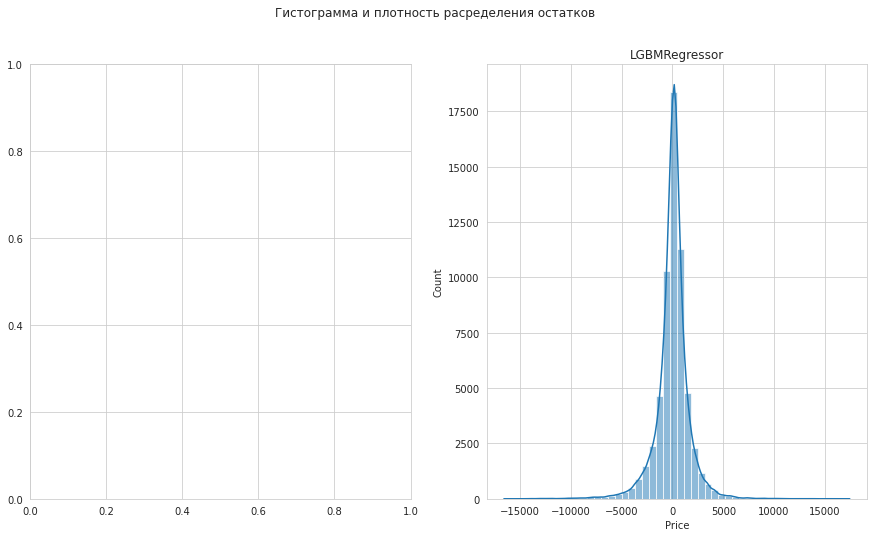

In [ ]:
figure, axs = plt.subplots(1, 2, figsize=(15, 8))
figure.suptitle('Гистограмма и плотность расределения остатков')

sns.histplot(y_valid_pred_svr - y_valid, bins=50, kde=True, ax=axs[0])
axs[0].set_title('SVR')

sns.histplot(y_valid_pred_lgbm - y_valid, bins=50, kde=True, ax=axs[1])
axs[1].set_title('LGBMRegressor')

plt.show()

### Вывод по шагу 3
По совокупности параметров оценки моделей, а так же по каждому из них в отдельности, `LGBMRegressor` является лучшей моделью из рассмотренных.

По распределению остатков тоже видим неоспоримое преиущество `LGBMRegressor`: распределение нормальное, симметричное с вершиной около нуля и крутыми склонами. Распределение остатков `SVR` не такое симметричное, левый склон более пологий; модель `SVR` заметно чаще преуменьшает стоимость автомобилей.

## 4. Тестирование лучшей модели

Проверим `LGBMRegressor` на тестовой выборке. А также посмотрим на значимость признаков для модели.

In [ ]:
X_test_lgbm = data_preprocessor_lgbm.transform(X_test_imputed)

In [ ]:
%%time
y_test_pred = model_lgbm.predict(X_test_lgbm)
print('LGBMRegressor. Метрика RMSE на тестовой выборке:',
     np.sqrt(mean_squared_error(y_test, y_test_pred)))

LGBMRegressor. Метрика RMSE на тестовой выборке: 1667.02753684504
CPU times: user 536 ms, sys: 0 ns, total: 536 ms
Wall time: 469 ms


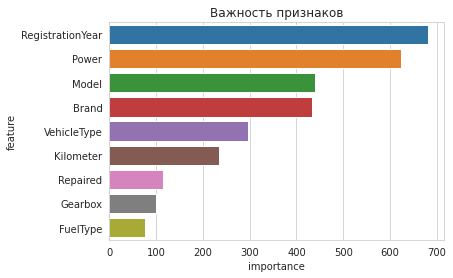

In [ ]:
df = pd.DataFrame(model_lgbm.feature_importances_, cat_columns + num_columns).sort_values(by=0, ascending=False).reset_index()
df.columns = ['feature', 'importance']

sns.barplot(x=df['importance'], y=df['feature'])
plt.title('Важность признаков')
plt.show()

На тестовой выборке модель показала приблизительно те же результаты, что и на валидационной.

Наиболее важными признаками оказались год регистрации, мощность двигателя и модель/бренд.

## Итоговые выводы

1. В ходе анализа и предобработки данных:
* обнаружили очень большое количество пропусков, аномалий и выбросов, 4 дубликата;
* удалили 11% строк;
* исключили из анализа и обучения признаки, не имеющие значения для целей проекта:
  - `DateCrawled`;      
  - `RegistrationMonth`;
  - `DateCreated`;
  - `NumberOfPictures`;   
  - `PostalCode`;  
  - `LastSeen`;
* пропуски в категориальных и количественных признаках частично восстановили модой для каждой модели;
* пропуски, которые не удалось восстановить, заменили на `unknown` (в шаге 3);
* отметили, что все потенциальные входные признаки имеют взаимосвязи с целевым признаком, но особенно сильной взаимосвязи у `Price` нет ни с одним из признаков.
2. Обучили и проанализировали 2 модели: `SVR` и `LGBMRegressor` (для них потребовалось использовать различные способы обработки). Только `LGBMRegressor` показала на валидационной выборке метрику *RMSE* меньше требуемых 2500. Она же оказалась гораздо быстрее. А также ее остатки более нормально распределены. Модель `LGBMRegressor` оказалась лучшей из рассмотренных.
3. Проверили `LGBMRegressor` на тестовой выборке и проанализировали важность признаков. Наиболее важными оказались год регистрации, мощность двигателя и модель/бренд.
4. Обученную модель можно применять для определения цены.